Business problem (big pciture)--ZL's version [rough idea while learning ML, still has a bit of gaps to concrete these steps]

1. Gain accurate prediction of house need (regression based model to predict house price values)

2. Output of regression can possibly fed into other algorithm to classify house pricing by zip/ district (so that one can make investment decision-- if we know the median house price by district) --> possible need to join other data to understand the demand side of infor by district (e.g., https://data.europa.eu/data/datasets/bx_hyaoipadv-q?locale=en)

3. productionise algorithm into visualisation/ api 


# 1️⃣ Data Preparation 
**designed by:** [datamover.ai](https://www.datamover.ai)

In [1]:
# create folder data if not exist
import os

# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# make script reproducible
np.random.seed(42)

**1 Fetch dataset**

Download dataset from this [url](https://www.kaggle.com/datasets/thomasnibb/amsterdam-house-price-prediction) and load the data in a `pd.DataFrame`. 

check this [article](https://www.datamover.ai/post/the-right-way-to-set-absolute-path-in-python) to learn how to load dataset OS agnostic

In [2]:
DATA_DIR = "data"
FILENAME = "HousingPrices-Amsterdam-August-2021.csv"

data = pd.read_csv(
    os.path.join(DATA_DIR, FILENAME), 
    index_col=0,
)
data.head()



,Address,Zip,Price,Area,Room,Lon,Lat
1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


In [3]:
data.shape

(924, 7)

In [4]:
data_copy = data.copy()

data_copy['price_per_area'] =data_copy['Price'] / data_copy['Area'] #created a measure of price per unit, for later visualisation 

In [5]:
data_copy['price_per_area']. describe()


count      920.000000
mean      6479.852299
std       2219.265218
min       2430.555556
25%       4649.086379
50%       6578.947368
75%       7768.912530
max      25252.808989
Name: price_per_area, dtype: float64

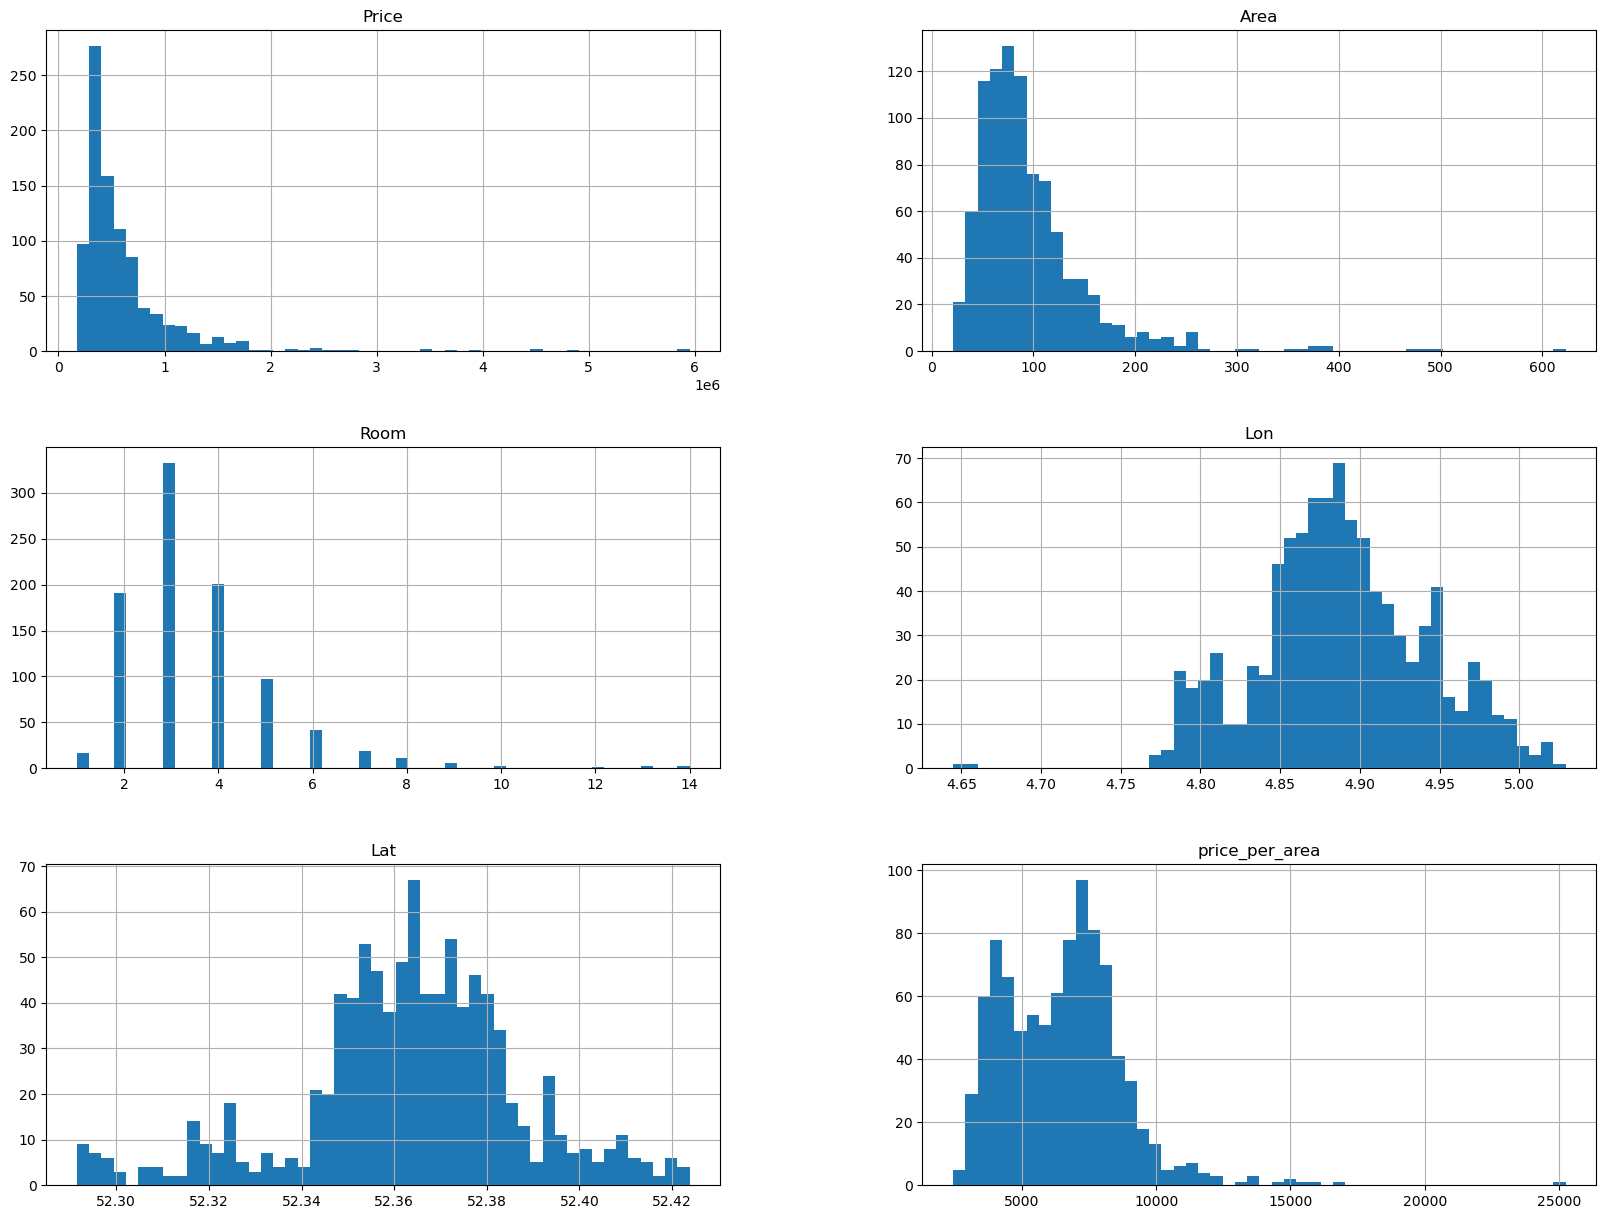

In [6]:
# visualise the data by checking histogram of numeric columns 

%matplotlib inline
import matplotlib.pyplot as plt
data_copy.hist(bins=50, figsize=(20,15))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


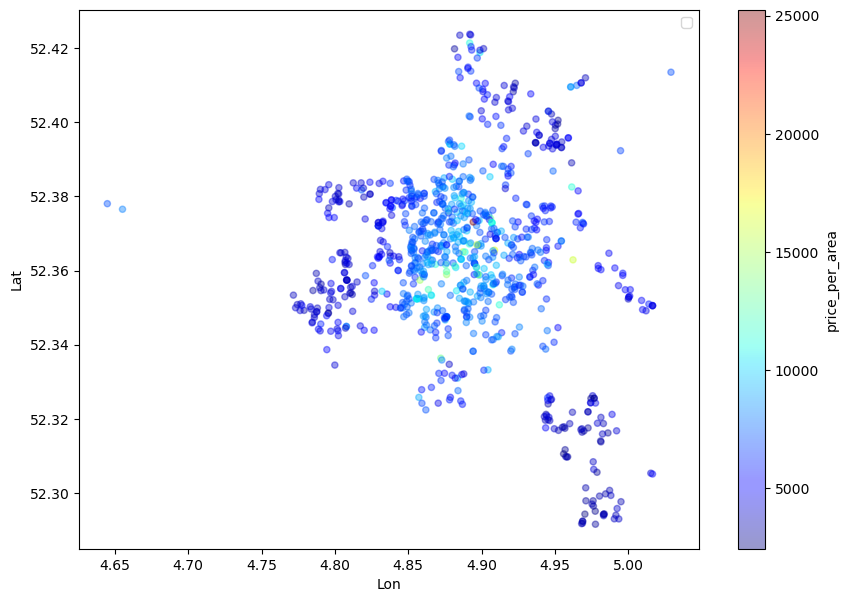

In [7]:
# data visualisation at a glance 
# when altering the data viz by geographic coordinates (with price and price per area respectively)
# -- it seems showing me that center house are more pricy per area (unit), which is expected; 
# at the same time also seems indicating central houses are smaller size than outskirts. 
data_copy.plot(kind='scatter', x= 'Lon', y= 'Lat', alpha = 0.4,  figsize=(10,7),
          c="price_per_area", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False) #modify to 'Price' for overall view 

plt.legend()

**2 Check size of dataset and make sure your workspace has enough storage if you are dealing with big datasets**

In [8]:
size_b = data.memory_usage(deep=True).sum()  # get size in byte
size_mb = size_b / (1024 * 1024)  # convert byte to mb
print(f"Size data: {size_mb:.2f} Mb")

# Note: deep=True introspect the data deeply by interrogating object dtypes for system-level memory consumption, and include it in the returned values.

Size data: 0.18 Mb


**3. Check type of data (time series, sample, geographical, etc.) and make sure they are what they should be.**

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924 entries, 1 to 924
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  924 non-null    object 
 1   Zip      924 non-null    object 
 2   Price    920 non-null    float64
 3   Area     924 non-null    int64  
 4   Room     924 non-null    int64  
 5   Lon      924 non-null    float64
 6   Lat      924 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 57.8+ KB


**4. If necessary, convert the data to a format that is easy to manipulate (without changing the data itself, e.g. .csv, .json).**

In this case the dataset are already in a format easy to manipulate, i.e., `.csv`

**5. For training of ML models, sample a hold-out set, put it aside, and never look at it ⚠️.**

- typical train/test splits are `60/40`, `70/30`, `80/20`;
- it is convenient to store train and test data separately;
- **Note:** often test set and hold-out are terms used interchangeably.

<ins> For this project aim to have a 80/20 train/test split ratio. <ins>

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [10]:
TARGET = "Price"  # get target name

# split data in train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=[TARGET]), data[TARGET], test_size=0.20, random_state=42
)

# re-merge X,y for both train and test
data_train = pd.merge(left=y_train, right=X_train, left_index=True, right_index=True)
data_test = pd.merge(left=y_test, right=X_test, left_index=True, right_index=True)

# double check sample size
print(
    f"# sample train set: {data_train.shape[0]} ({data_train.shape[0]/len(data):.2f}%) "
)
print(f"# sample test set: {data_test.shape[0]} ({data_test.shape[0]/len(data):.2f}%) ")

# sample train set: 739 (0.80%) 
# sample test set: 185 (0.20%) 


**⬇️ Store train and test locally**
- store both dataset in `csv` format
- save train and test set as `data_train.csv` and `data_set.csv`, respectively.
- in both dataset make sure to retain the column names and discard the index as it is not informative.

In [11]:
if not os.path.exists("data"):
    os.makedirs("data")

# save data
data_train.to_csv(
    path_or_buf="./data/data_train.csv",
    header=True,  # Write out the column names
    index=False,  # discard index as it is not informative
)

data_test.to_csv(
    path_or_buf="./data/data_test.csv",
    header=True,  # Write out the column names
    index=False,  # discard index as it is not informative
)

#### Analysis plans: 

I followed the book 'modern statistics with R' chapter 9 to first executive several methods for predictive modelling ( https://www.modernstatisticswithr.com/mlchapter.html)

Prior to the analysis, I first inspected the data and removed 4 observations of missing data for price variable 

I then relied on data visualisation for exploratory analysis 

##### Data inspection and preparation

In [12]:
# target variable showed 4 missing value, decided to drop them later,
# as not sure if they are missing at random
data.isna().sum()



Address    0
Zip        0
Price      4
Area       0
Room       0
Lon        0
Lat        0
dtype: int64

In [13]:
print(f'Missing value percentage: {round(data.Price.isna().sum()/ len(data)*100,2)}%')

Missing value percentage: 0.43%


In [14]:
#inspect missing data
missing = data.loc[(data.Price.isna())]
missing

,Address,Zip,Price,Area,Room,Lon,Lat
74,"Falckstraat 47 A, Amsterdam",1017 VV,NaN,147,3,4.897454,52.360707
322,"Haarlemmerweg 705, Amsterdam",1067 HP,NaN,366,12,4.787874,52.383877
611,"Zeeburgerkade 760, Amsterdam",1019 HT,NaN,107,3,4.945022,52.369244
728,"Suikerplein 16, Amsterdam",1013 CK,NaN,81,3,4.880976,52.389623


In [15]:
#drop missing data 
cleaned_dat = data.dropna()
cleaned_dat.isna().sum()
# cleaned_dat.info()

Address    0
Zip        0
Price      0
Area       0
Room       0
Lon        0
Lat        0
dtype: int64

In [16]:
cleaned_dat.shape

(920, 7)

In [17]:
# import seaborn as sns
# sns.boxplot(y= cleaned_dat['Price'])

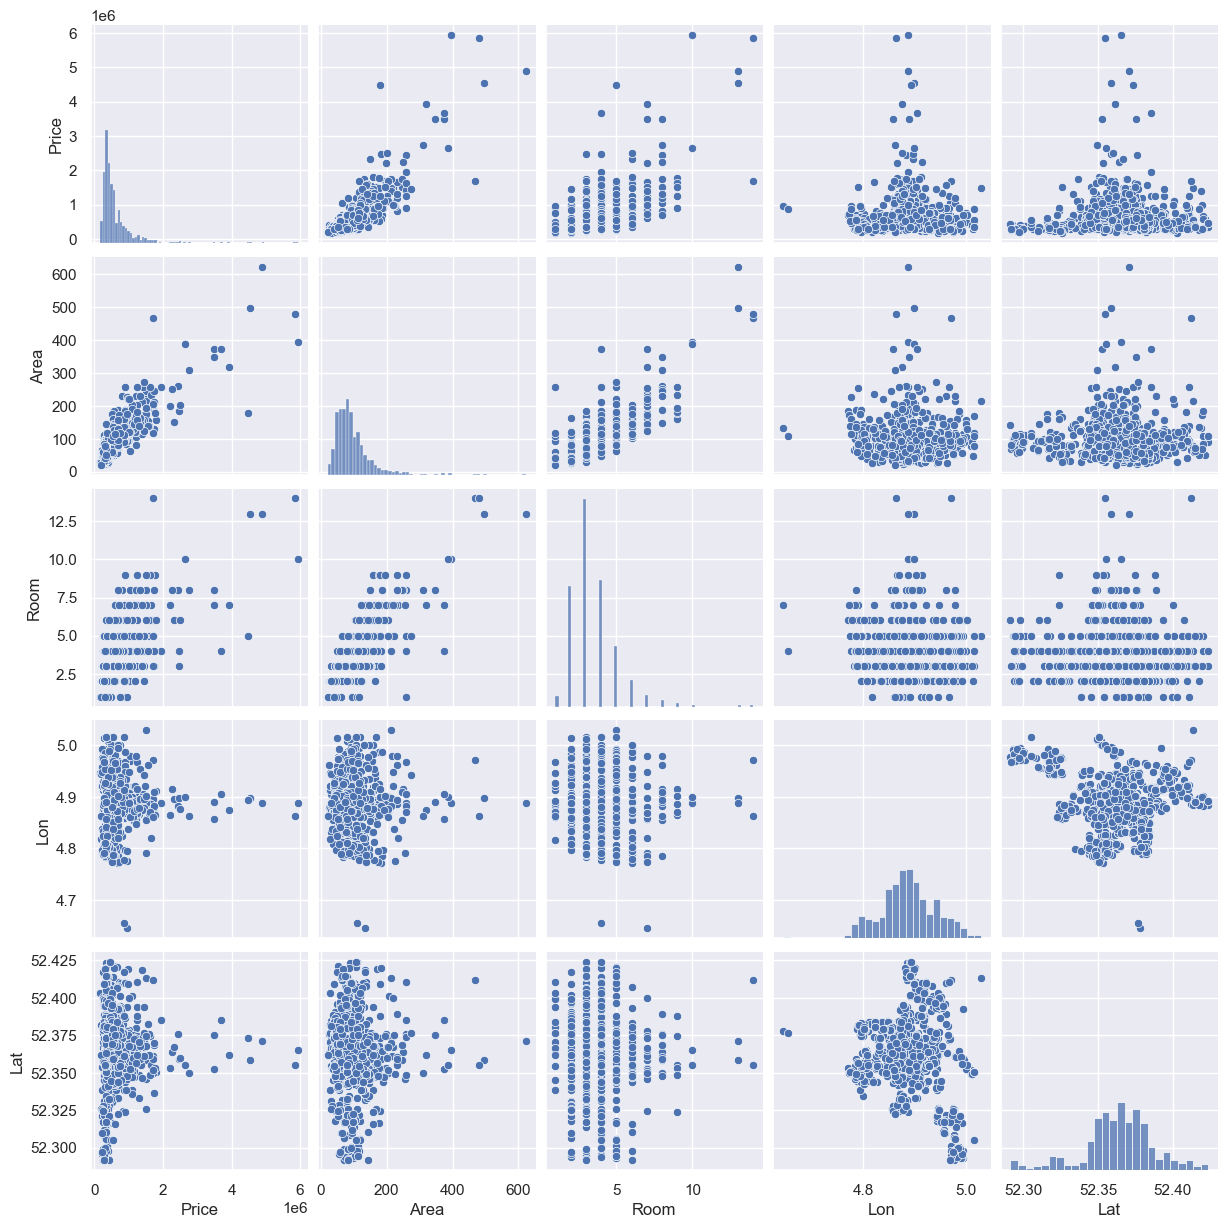

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so
sns.set(palette='deep')

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

sns.pairplot(cleaned_dat[['Price','Area','Room','Lon','Lat']])

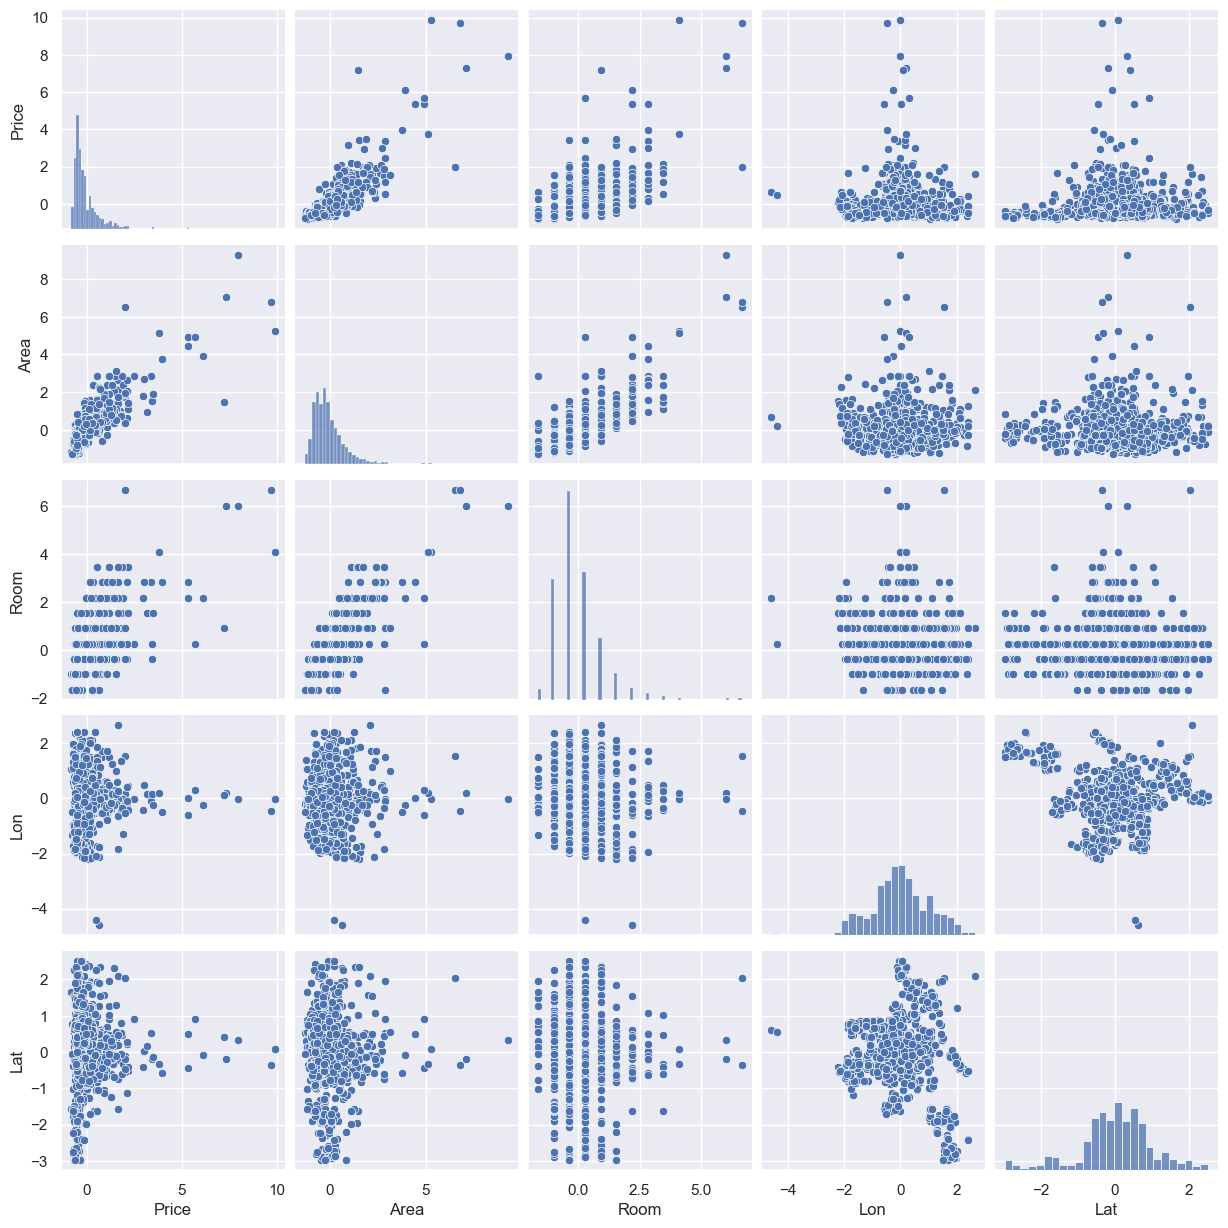

In [19]:
#visualise data after standardisation 

from sklearn import preprocessing

scaler = preprocessing.StandardScaler() #create object for data standardisation 

df = cleaned_dat[['Price','Area','Room','Lon','Lat']]

#transform the features 
standardised = scaler.fit_transform(df)
standardised = pd.DataFrame(standardised, columns=['Price','Area','Room','Lon','Lat'])

sns.pairplot(standardised)

In [20]:
cleaned_dat.describe()

,Price,Area,Room,Lon,Lat
count,9.200000e+02,920.000000,920.00000,920.000000,920.000000
mean,6.220654e+05,95.607609,3.56413,4.888652,52.363271
std,5.389942e+05,56.849699,1.57103,0.053118,0.024054
min,1.750000e+05,21.000000,1.00000,4.644819,52.291519
25%,3.500000e+05,60.000000,3.00000,4.855834,52.351925
50%,4.670000e+05,83.000000,3.00000,4.886818,52.364499
75%,7.000000e+05,113.000000,4.00000,4.922337,52.377545
max,5.950000e+06,623.000000,14.00000,5.029122,52.423805


In [21]:
standardised.describe()

,Price,Area,Room,Lon,Lat
count,9.200000e+02,9.200000e+02,9.200000e+02,9.200000e+02,9.200000e+02
mean,9.267949e-17,-7.723291e-18,3.861645e-17,8.881784e-17,-1.021482e-13
std,1.000544e+00,1.000544e+00,1.000544e+00,1.000544e+00,1.000544e+00
min,-8.298950e-01,-1.313080e+00,-1.633021e+00,-4.592911e+00,-2.984555e+00
25%,-5.050396e-01,-6.266872e-01,-3.592785e-01,-6.181671e-01,-4.719682e-01
50%,-2.878505e-01,-2.218915e-01,-3.592785e-01,-3.454822e-02,5.105979e-02
75%,1.446713e-01,3.061028e-01,2.775928e-01,6.345073e-01,5.937311e-01
max,9.890334e+00,9.282006e+00,6.646306e+00,2.645931e+00,2.517903e+00


/var/folders/m6/h_c6j54j54723kby9c10j_0m0000gn/T/ipykernel_24608/2356054330.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = cleaned_dat.corr().round(2)


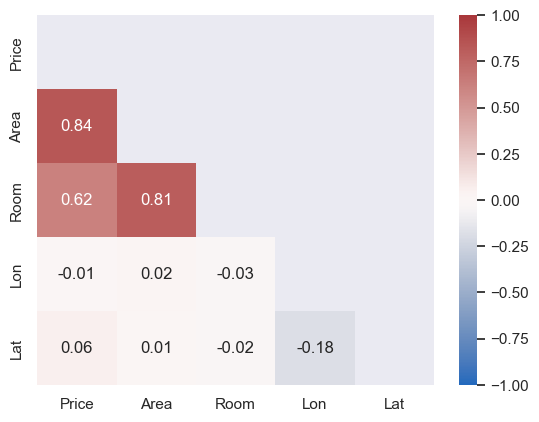

In [22]:
# visualise correlation matrix among variables 
matrix = cleaned_dat.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

### Data Analyis
##### Method 1 : Test-training splits (linear regression)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


In [23]:
# missing_trans = lambda x: x.fillna(x.mean())
# data.transform(missing_trans)

In [24]:
data_train.dropna(inplace= True)
predictor = ["Area", "Room", "Lon", "Lat"]
X = data_train[predictor]
Y = data_train["Price"]

In [25]:
#fitting training data into linear model 
#display regression intercept, coefficients and R-squared value of model

reg = LinearRegression().fit(X, Y)
r_square = reg.score(X, Y)


print('Intercept:', reg.intercept_)
print('Coefficents:', reg.coef_) 

print(f"R_squared : {round(r_square,3)}")

Intercept: -32931829.860206537
Coefficents: [   8588.04104179  -51934.27494094 -312968.98509219  657803.01942997]
R_squared : 0.65


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X1 = data_test[predictor]
Ypred = reg.predict(X1)

mae = mean_absolute_error(y_test, Ypred)
rmse = mean_squared_error(y_test, Ypred, squared = False)

print(f"MAE : {round(mae,3)}")
print(f"RMSE : {round(rmse,3)}")

MAE : 189561.579
RMSE : 313385.175


In [27]:
# # Plot outputs
# ADD

# plt.plot(X,Y,'r.')
# plt.show()

In [28]:
# import statsmodels.api as sm

# #add constant to predictor variables
# x = sm.add_constant(X)
# #fit linear regression model
# model = sm.OLS(Y, X).fit()
# #view model summary
# print(model.summary())

#### Method 2: Cross-validation

##### Note: interpretability of this method a bit unclear (i.e., predictive performance compared to linear model)


#### Method 2.1: Leave-one-out cross-validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html

In [29]:
from sklearn.model_selection import LeaveOneOut

#drop missing data 
# cleaned_dat = data.dropna()
predictor = ["Area", "Room", "Lon", "Lat"]
target = "Price"

X = cleaned_dat[predictor]
Y = cleaned_dat[target]

loo = LeaveOneOut()
# N = 920, after removing missing data, I will then run 920 regressions with cross validation 
# and to compare each prediction of each model to the actual target value
loo.get_n_splits(X) 


920

In [30]:
## MAE and RMSE here had the same value, not sure if I have missed anything
# I read from the book leaveoneout may have limitation when there are very similar observations, not sure if this is the cause 

import statistics 
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = []
rmse = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    reg = LinearRegression().fit(X.iloc[train_index], Y.iloc[train_index])
    ypred = reg.predict(X.iloc[test_index])
    mae.append(mean_absolute_error(Y.iloc[test_index], ypred))
    rmse.append(mean_squared_error(Y.iloc[test_index], ypred, squared = False))
    

print(f"MAE: {round(sum(mae)/len(mae), 3)}")
print(f"RMSE: {round(sum(rmse)/len(rmse), 3)}")

MAE: 180635.13
RMSE: 180635.13


##### Method 2.2 K-fold cross validation 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold 

In [31]:
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predictor = ["Area", "Room", "Lon", "Lat"]
target = "Price"

X = cleaned_dat[predictor]
Y = cleaned_dat[target]

kf = KFold(n_splits = 10)

#predictive metrics became larger when running more iterations
rkf = RepeatedKFold(n_splits=10, n_repeats=5000, random_state = 42)
r2 = [] 
mae = []
rmse = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
# for i, (train_index, test_index) in enumerate(rkf.split(X)):
    reg = LinearRegression().fit(X.iloc[train_index], Y.iloc[train_index])
    ypred = reg.predict(X.iloc[test_index])
    r2.append(r2_score(Y.iloc[test_index], ypred))
    mae.append(mean_absolute_error(Y.iloc[test_index], ypred))
    rmse.append(mean_squared_error(Y.iloc[test_index], ypred, squared = False))
    
print(f"r2_score: {round(sum(r2)/len(r2), 3)}")
print(f"MAE: {round(sum(mae)/len(mae), 3)}")
print(f"RMSE: {round(sum(rmse)/len(rmse), 3)}")

r2_score: 0.535
MAE: 181219.183
RMSE: 276316.751


#### Output summary 

##### *` Using raw data (unstandardised)`*
| Method                | MAE            | RMSE                | R^2      |
|-----------------------|----------------|---------------------|----------|
| Linear model          | 189561.579     | 313385.175          |    0.65  |
| CV_LeaveOneOut        | 180635.13      | 180635.13           |     /    |
| CV_KFold              | 173133.782     | 280139.66           |   0.535  |
| CV_RepeatedKFold      | 180823.214     | 285563.127          |   0.654  |


##### *` Regularised regression`*


|    Method              | MAE            | RMSE                | R^2      |
|------------------------|----------------|---------------------|----------|
| Ridge_Linear model     | 0.306          | 0.459               | 0.683    |
| Ridge_CV_LeaveOneOut   | 0.335          | 0.335               |     /    |
| Lasso_Linear model     | 0.601          | 1.024               |     0    | 
| Lasso_CV_LeaveOneOut   | 0.576          | 0.576               |     /    |
| ElasticNet_Linear model| 0.476          | 0.837               |  0.295   |
<!-- | ElasticNet_Linear model|                |                     |          | -->


#### Method 3: Regularised regressions 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html


##### Method 3.1 Ridge Model

In [32]:
# data pre-processing: before regularised regression, I standardised the data with standardscaler 

from sklearn import preprocessing

scaler = preprocessing.StandardScaler() #create object for data standardisation 

df = cleaned_dat[['Price','Area','Room','Lon','Lat']] #data after remove missing data 

#transform the features 
standardised = scaler.fit_transform(df)
standardised = pd.DataFrame(standardised, columns=['Price','Area','Room','Lon','Lat'])


#Create split of test and train based on pre-processed data (after standardisation )
TARGET = "Price"  # get target name

# split data in train and test
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    standardised.drop(columns=[TARGET]), standardised[TARGET], test_size=0.20, random_state=42
)

# re-merge X,y for both train and test
data_train_s = pd.merge(left=y_train_s, right=X_train_s, left_index=True, right_index=True)
data_test_s = pd.merge(left=y_test_s, right=X_test_s, left_index=True, right_index=True)

# double check sample size
print(
    f"# sample train set: {data_train_s.shape[0]} ({data_train_s.shape[0]/len(standardised):.2f}%) "
)
print(f"# sample test set: {data_test_s.shape[0]} ({data_test_s.shape[0]/len(standardised):.2f}%) ")


# sample train set: 736 (0.80%) 
# sample test set: 184 (0.20%) 


In [33]:
## Ridge regression with linear model 
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

scaler = preprocessing.StandardScaler() #create object for data standardisation 
clf = Ridge(alpha=1.0)


predictor = ["Area", "Room", "Lon", "Lat"]
X = data_train_s[predictor]

#transform the features 
Y = data_train_s["Price"]

reg = clf.fit(X, Y)
r_square = reg.score(X, Y)


print('Intercept:', reg.intercept_)
print('Coefficents:', reg.coef_) 

print(f"R_squared : {round(r_square,3)}")


X1 = data_test_s[predictor]

Ypred_s = reg.predict(X1)

mae = mean_absolute_error(y_test_s, Ypred_s)
rmse = mean_squared_error(y_test_s, Ypred_s, squared = False)


print(f"MAE : {round(mae,3)}")
print(f"RMSE : {round(rmse,3)}")



Intercept: 0.0031241642870558153
Coefficents: [ 0.93205761 -0.11995583 -0.03213032  0.03274397]
R_squared : 0.683
MAE : 0.306
RMSE : 0.459


In [34]:
### Ridge regression with LeaveOneOut method 
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error


predictor = ["Area", "Room", "Lon", "Lat"]
target = "Price"

X = standardised[predictor]
Y = standardised[target]

clf = RidgeCV(alphas=1)

mae = []
rmse = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    reg = clf.fit(X.iloc[train_index], Y.iloc[train_index])
    ypred = reg.predict(X.iloc[test_index])
    mae.append(mean_absolute_error(Y.iloc[test_index], ypred))
    rmse.append(mean_squared_error(Y.iloc[test_index], ypred, squared = False))
    

print(f"negative mean squared error: {round(clf.score(X, Y),2)}")
print(f"MAE: {round(sum(mae)/len(mae), 3)}")
print(f"RMSE: {round(sum(rmse)/len(rmse), 3)}")

negative mean squared error: 0.71
MAE: 0.335
RMSE: 0.335


##### Method 3.2 Lasso model 

The model simultaneously performs estimation and variable selection, by completely removing some variables from the model.

In [35]:
## Lasso regression with linear model 
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

clf = linear_model.Lasso(alpha=1)


predictor = ["Area", "Room", "Lon", "Lat"]
X = data_train_s[predictor]
Y = data_train_s["Price"]

reg = clf.fit(X, Y)
r_square = reg.score(X, Y)


print('Intercept:', reg.intercept_)
print('Coefficents:', reg.coef_) 

print(f"R_squared : {round(r_square,4)}")


X1 = data_test_s[predictor]
Ypred_s = reg.predict(X1)

mae = mean_absolute_error(y_test_s, Ypred_s)
rmse = mean_squared_error(y_test_s, Ypred_s, squared = False)

print(f"MAE : {round(mae,3)}")
print(f"RMSE : {round(rmse,3)}")

Intercept: -0.003089026605375276
Coefficents: [ 0.  0. -0.  0.]
R_squared : 0.0
MAE : 0.601
RMSE : 1.024


In [36]:
### Lasso regression with LeaveOneOut method 
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error


predictor = ["Area", "Room", "Lon", "Lat"]
target = "Price"

X = standardised[predictor]
Y = standardised[target]

loo = LeaveOneOut()
clf = linear_model.Lasso(alpha=1.0)

mae = []
rmse = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    reg = clf.fit(X.iloc[train_index], Y.iloc[train_index])
    ypred = reg.predict(X.iloc[test_index])
    mae.append(mean_absolute_error(Y.iloc[test_index], ypred))
    rmse.append(mean_squared_error(Y.iloc[test_index], ypred, squared = False))
    

print(f"MAE: {round(sum(mae)/len(mae), 3)}")
print(f"RMSE: {round(sum(rmse)/len(rmse), 3)}")

MAE: 0.576
RMSE: 0.576


In [37]:
from numpy import arange
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV


predictor = ["Area", "Room", "Lon", "Lat"]
X = data_train_s[predictor]
Y = data_train_s["Price"]

# define model
regr = ElasticNet(random_state=42)
reg = regr.fit(X, Y)
r_square = reg.score(X, Y)

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)


X1 = data_test_s[predictor]
Ypred_s = reg.predict(X1)

mae = mean_absolute_error(y_test_s, Ypred_s)
rmse = mean_squared_error(y_test_s, Ypred_s, squared = False)

print('Intercept:', reg.intercept_)
print('Coefficents:', reg.coef_) 

print(f"R_squared : {round(r_square,4)}")

print(f"MAE : {round(mae,3)}")
print(f"RMSE : {round(rmse,3)}")

# define parameters
param = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'l1_ratio': arange(0, 1, 0.01),
    'fit_intercept':[True, False]
}

# define search
search = GridSearchCV(regr, param, 
                      scoring= 'r2', #, 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_error'
                      n_jobs=-1, cv=cv)
# execute search
result = search.fit(X, Y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_) # this seems to suggest Lasso is the best model, but did not correspond to what i tested above 



Intercept: -0.0019342624725624195
Coefficents: [ 0.20707829  0.         -0.          0.        ]
R_squared : 0.2952
MAE : 0.476
RMSE : 0.837


/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.025e+01, tolerance: 6.362e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.164e+01, tolerance: 5.317e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

Best Score: 0.611394566663346
Best Hyperparameters: {'alpha': 0.1, 'fit_intercept': False, 'l1_ratio': 0.89}


#### Cleaning up the code - automating regression output 

Draw inspirations from this link below, but the output did not give me consistent results compared to above i did one by one --- NEED DISCUSSION 


https://machinelearninghd.com/gridsearchcv-hyperparameter-tuning-sckit-learn-regression-classification/ 

In [38]:
#Importing Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [39]:
# data pre-processing: before regularised regression, I standardised the data with standardscaler 

from sklearn import preprocessing

scaler = preprocessing.StandardScaler() #create object for data standardisation 

df = cleaned_dat[['Price','Area','Room','Lon','Lat']] #data after remove missing data 

#transform the features 
standardised = scaler.fit_transform(df)
standardised = pd.DataFrame(standardised, columns=['Price','Area','Room','Lon','Lat'])


#Create split of test and train based on pre-processed data (after standardisation )
TARGET = "Price"  # get target name

# split data in train and test
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    standardised.drop(columns=[TARGET]), standardised[TARGET], test_size=0.20, random_state=42
)

# re-merge X,y for both train and test
data_train_s = pd.merge(left=y_train_s, right=X_train_s, left_index=True, right_index=True)
data_test_s = pd.merge(left=y_test_s, right=X_test_s, left_index=True, right_index=True)

# double check sample size
print(
    f"# sample train set: {data_train_s.shape[0]} ({data_train_s.shape[0]/len(standardised):.2f}%) "
)
print(f"# sample test set: {data_test_s.shape[0]} ({data_test_s.shape[0]/len(standardised):.2f}%) ")

# sample train set: 736 (0.80%) 
# sample test set: 184 (0.20%) 


In [40]:
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from time import time

from sklearn.linear_model import LinearRegression, Ridge,Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

In [41]:
regressors = [
    LinearRegression(),
    Lasso(),
    Ridge(), 
    ElasticNet()
]

##### Note: 

I first implemented my learning from the book to test each model/ method one by one, in the end i tried to incorporate what I read on line to put things altogether (see below section)

However, there are nuance differences of output (mostly R^2), worth also have a discussion 

In [42]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train_s, y_train_s)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test_s)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test_s, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test_s, y_pred))
    print("\tR2 score:", r2_score(y_test_s, y_pred))
    print()

LinearRegression()
	Training time: 0.016s
	Prediction time: 0.001s
	Explained variance: 0.8000583112565085
	Mean absolute error: 0.3058391118724273
	R2 score: 0.7998106641653244

Lasso()
	Training time: 0.001s
	Prediction time: 0.001s
	Explained variance: 0.0
	Mean absolute error: 0.6012521396557684
	R2 score: -0.00022734623108444652

Ridge()
	Training time: 0.001s
	Prediction time: 0.001s
	Explained variance: 0.7997427592074348
	Mean absolute error: 0.30572758723924787
	R2 score: 0.7995102114325207

ElasticNet()
	Training time: 0.001s
	Prediction time: 0.001s
	Explained variance: 0.33235509419479436
	Mean absolute error: 0.47575732683033395
	R2 score: 0.33226595365222156



##### *` Using raw data (unstandardised)`*
| Method                | MAE            | RMSE                | R^2      |
|-----------------------|----------------|---------------------|----------|
| Linear model          | 189561.579     | 313385.175          |    0.65  |
| CV_LeaveOneOut        | 180635.13      | 180635.13           |     /    |
| CV_KFold              | 173133.782     | 280139.66           |   0.535  |
| CV_RepeatedKFold      | 180823.214     | 285563.127          |   0.654  |


##### *` Regularised regression`*


|    Method              | MAE            | RMSE                | R^2      |
|------------------------|----------------|---------------------|----------|
| Ridge_Linear model     | 0.306          | 0.459               | 0.683    |
| Ridge_CV_LeaveOneOut   | 0.335          | 0.335               |     /    |
| Lasso_Linear model     | 0.601          | 1.024               |     0    | 
| Lasso_CV_LeaveOneOut   | 0.576          | 0.576               |     /    |
| ElasticNet_Linear model| 0.476          | 0.837               |  0.295   |
<!-- | ElasticNet_Linear model|                |                     |          | -->
